## Import Statements

In [1]:
# code
# !pip install timm shap lime opencv-python

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from PIL import Image
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

# timm: PyTorch Image Models
import timm

# For Grad-CAM
import cv2
import torch.nn.functional as F

# SHAP
import shap

# LIME
from lime import lime_image
from skimage.segmentation import mark_boundaries


## Train CNN EfficientNet Model

In [10]:
TRAIN_DIR = 'archive/real-vs-fake/train'
VAL_DIR   = 'archive/real-vs-fake/valid'
TEST_DIR  = 'archive/real-vs-fake/test'

# Hyperparameters
BATCH_SIZE    = 32
NUM_EPOCHS    = 5
LEARNING_RATE = 1e-4
IMG_SIZE      = 224  #(EfficientNet-B0 default)
DEVICE        = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cuda


In [12]:
# Define transformations
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])  # ImageNet stats
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
val_dataset   = datasets.ImageFolder(VAL_DIR, transform=val_transforms)
test_dataset  = datasets.ImageFolder(TEST_DIR, transform=val_transforms)

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# real_dataset  = datasets.ImageFolder("temp/real", transform=val_transforms)
# real_loader  = DataLoader(real_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
# 
# fake_dataset  = datasets.ImageFolder("temp/fake", transform=val_transforms)
# fake_loader  = DataLoader(fake_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Check class to index mapping
print("Classes:", train_dataset.classes)

Classes: ['fake', 'real']


In [9]:
# from glob import glob
# real_path = glob("temp/real/*.jpg")  
# fake_path = glob("temp/fake/*.jpg")  
# 
# # Load and transform images
# real_images = [val_transforms(Image.open(path).convert("RGB")) for path in real_path]
# fake_images = [val_transforms(Image.open(path).convert("RGB")) for path in fake_path]

In [13]:
model = timm.create_model('efficientnet_b0', pretrained=True)

# Replace classifier for 2 classes
# EfficientNet-B0 in timm has a classifier named "classifier"
num_features     = model.classifier.in_features
model.classifier = nn.Linear(num_features, 2)

model = model.to(DEVICE)

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(model)

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2

In [ ]:
#Training the model
from tqdm import tqdm 

def train_one_epoch(model, train_loader, optimizer, criterion, device=DEVICE):
    model.train()
    running_loss = 0.0
    correct      = 0
    total        = 0
    
    # Wrap your loader with tqdm for a progress bar
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss    = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct      += (predicted == labels).sum().item()
        total        += labels.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc  = correct / total
    return epoch_loss, epoch_acc

def validate_one_epoch(model, val_loader, criterion, device=DEVICE):
    model.eval()
    running_loss = 0.0
    correct      = 0
    total        = 0
    
    # Wrap your loader with tqdm for a progress bar
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validating", leave=False):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss    = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct      += (predicted == labels).sum().item()
            total        += labels.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc  = correct / total
    return epoch_loss, epoch_acc

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE)
    val_loss, val_acc     = validate_one_epoch(model, val_loader, criterion, DEVICE)
    
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f}, Val Acc:   {val_acc:.4f}")

# Save the trained model
torch.save(model.state_dict(), 'efficientnet_b0_real_vs_fake.pth')
print("Model saved to efficientnet_b0_real_vs_fake.pth")

Epoch [1/5]
Train Loss: 0.0586, Train Acc: 0.9767
Val Loss:   0.0079, Val Acc:   0.9978


Epoch [2/5]
Train Loss: 0.0103, Train Acc: 0.9964
Val Loss:   0.0070, Val Acc:   0.9980


Epoch [3/5]
Train Loss: 0.0065, Train Acc: 0.9978
Val Loss:   0.0049, Val Acc:   0.9986


Epoch [4/5]
Train Loss: 0.0054, Train Acc: 0.9983
Val Loss:   0.0569, Val Acc:   0.9776


Epoch [5/5]
Train Loss: 0.0039, Train Acc: 0.9987
Val Loss:   0.0045, Val Acc:   0.9985
Model saved to efficientnet_b0_real_vs_fake.pth


In [14]:
# Load the trained model instead of retraining
DEVICE        = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)
model            = timm.create_model('efficientnet_b0', pretrained=False)
num_features     = model.classifier.in_features
model.classifier = nn.Linear(num_features, 2)

model.load_state_dict(torch.load('efficientnet_b0_real_vs_fake.pth', map_location=DEVICE))
model = model.to(DEVICE)
model.eval()

print("Model loaded and ready for inference!")

Using device: cuda
Model loaded and ready for inference!


In [35]:
# Testing
model.eval()
test_correct = 0
test_total   = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs        = model(images)
        _, predicted   = torch.max(outputs, 1)
        test_correct   += (predicted == labels).sum().item()
        test_total     += labels.size(0)

test_acc = test_correct / test_total
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.9986


## GRAD-CAM Implementation

In [36]:
def grad_cam(model, image_tensor, class_idx=None, device=DEVICE):
    """
    model        : trained model
    image_tensor : single image tensor of shape (1, C, H, W)
    class_idx    : which class to visualize Grad-CAM for. If None, uses predicted class.
    """
    model.eval()

    # We assume last convolution layer is the "blocks[-1]" in efficientnet.
    # For different architectures, you may need to adjust.
    target_layer = model.blocks[-1][-1].conv_pw  # last conv layer
    # If you are unsure, print(model) to identify a suitable last conv.

    # Hook to capture features and gradients
    conv_output = []
    grad_output = []

    def forward_hook(module, inp, out):
        conv_output.append(out)

    def backward_hook(module, grad_in, grad_out):
        grad_output.append(grad_out[0])

    forward_handle  = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_backward_hook(backward_hook)

    # Forward pass
    output = model(image_tensor.to(device))
    if class_idx is None:
        class_idx = torch.argmax(output, dim=1).item()

    # Zero grads
    model.zero_grad()
    # Backward pass on the chosen class
    loss = output[0, class_idx]
    loss.backward()

    # Get features and gradients
    activations = conv_output[0].detach().cpu().numpy()[0, :]
    gradients   = grad_output[0].detach().cpu().numpy()[0, :]

    # Global average pool the gradients
    weights = np.mean(gradients, axis=(1, 2))

    # Compute weighted combination of activations
    cam = np.zeros(activations.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * activations[i, :, :]

    # ReLU
    cam = np.maximum(cam, 0)
    # Normalize
    cam -= np.min(cam)
    cam /= np.max(cam) if np.max(cam) != 0 else 1

    # Remove hooks
    forward_handle.remove()
    backward_handle.remove()

    return cam, class_idx

def show_grad_cam_on_image(img_pil, cam):
    """
    Overlays the Grad-CAM heatmap on the original image
    """
    img     = np.array(img_pil)
    h, w, _ = img.shape
    cam = cv2.resize(cam, (w, h))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    overlay_img = heatmap + np.float32(img) / 255
    overlay_img = overlay_img / np.max(overlay_img)
    return np.uint8(255 * overlay_img)




Truth:  1
Prediction:  1


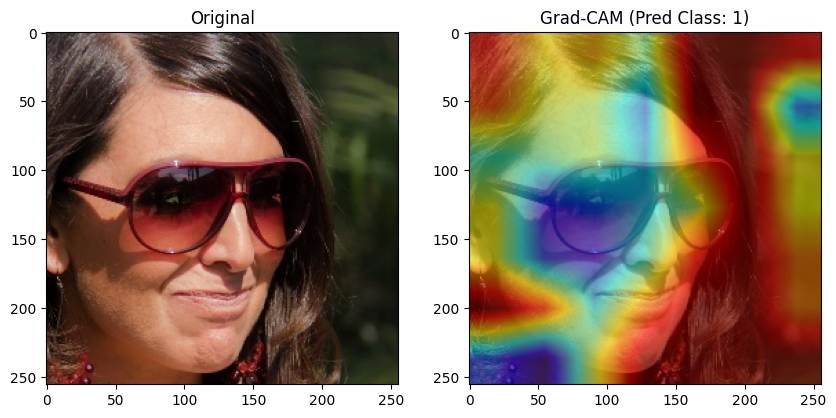

In [47]:
# Example usage on a single validation image
example_img_path, ground_truth = val_dataset.samples[11991]  # get path of first validation image
example_img_pil     = Image.open(example_img_path).convert('RGB')
transform           = val_transforms
example_img_tensor  = transform(example_img_pil).unsqueeze(0)  # shape: (1, C, H, W)

_, predicted_class = grad_cam(model, example_img_tensor, None)
cam, _ = grad_cam(model, example_img_tensor, 1)
grad_cam_result      = show_grad_cam_on_image(example_img_pil, cam)

print("Truth: ", ground_truth)
print("Prediction: ",predicted_class)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(example_img_pil)

plt.subplot(1,2,2)
plt.title(f"Grad-CAM (Pred Class: {predicted_class})")
plt.imshow(grad_cam_result)
plt.show()

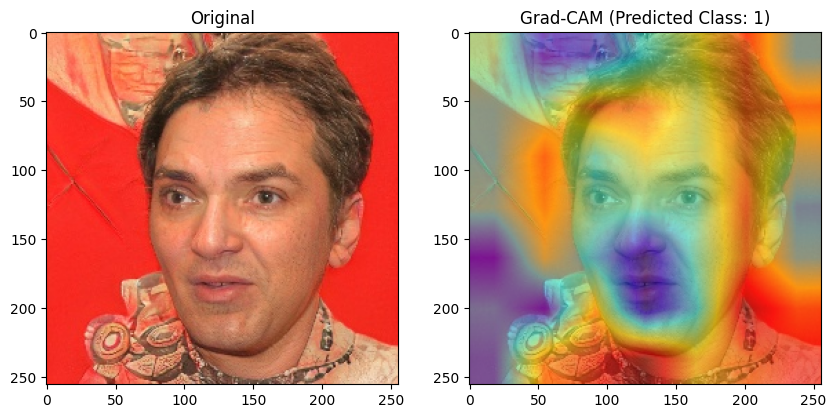

In [15]:
# import torch
# import numpy as np
# import cv2
# import matplotlib.pyplot as plt
# from PIL import Image
# 
# def grad_cam(model, image_tensor, class_idx=None, device="cuda"):
#     model.eval()
# 
#     # Modify this based on your model's architecture
#     target_layer = model.blocks[-1][-1].conv_pw
# 
#     conv_output = []
#     grad_output = []
# 
#     def forward_hook(module, inp, out):
#         conv_output.append(out)
# 
#     def backward_hook(module, grad_in, grad_out):
#         grad_output.append(grad_out[0])
# 
#     forward_handle = target_layer.register_forward_hook(forward_hook)
#     backward_handle = target_layer.register_backward_hook(backward_hook)
# 
#     # Forward pass
#     image_tensor = image_tensor.to(device)
#     output = model(image_tensor)
#     if class_idx is None:
#         class_idx = torch.argmax(output, dim=1).item()
# 
#     model.zero_grad()
#     loss = output[0, class_idx]
#     loss.backward()
# 
#     activations = conv_output[0].detach().cpu().numpy()[0, :]
#     gradients = grad_output[0].detach().cpu().numpy()[0, :]
# 
#     weights = np.mean(gradients, axis=(1, 2))
# 
#     cam = np.zeros(activations.shape[1:], dtype=np.float32)
#     for i, w in enumerate(weights):
#         cam += w * activations[i, :, :]
# 
#     cam = np.maximum(cam, 0)
#     cam -= np.min(cam)
#     cam /= np.max(cam) if np.max(cam) != 0 else 1
# 
#     forward_handle.remove()
#     backward_handle.remove()
# 
#     return cam, class_idx
# 
# def show_grad_cam_on_image(img_pil, cam):
#     img = np.array(img_pil)
#     h, w, _ = img.shape
#     cam = cv2.resize(cam, (w, h))
#     heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
#     heatmap = np.float32(heatmap) / 255
#     overlay_img = heatmap + np.float32(img) / 255
#     overlay_img = overlay_img / np.max(overlay_img)
#     return np.uint8(255 * overlay_img)
# 
# # Example usage on a direct image path
# image_path = "temp/fake/fake_image_15.jpg"  # replace with your image path
# 
# # Define your transforms
# from torchvision import transforms
# val_transforms = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor()
# ])
# 
# # Load and preprocess image
# img_pil = Image.open(image_path).convert("RGB")
# img_tensor = val_transforms(img_pil).unsqueeze(0)  # shape: (1, C, H, W)
# 
# # Grad-CAM
# cam, pred_class = grad_cam(model, img_tensor, device=DEVICE)
# result_img = show_grad_cam_on_image(img_pil, cam)
# 
# Image.fromarray(result_img).save("temp/fake/fake_image_15_exp.jpg")
# 
# # Show result
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.title("Original")
# plt.imshow(img_pil)
# 
# plt.subplot(1, 2, 2)
# plt.title(f"Grad-CAM (Predicted Class: {pred_class})")
# plt.imshow(result_img)
# plt.show()


## SHAP Implementation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


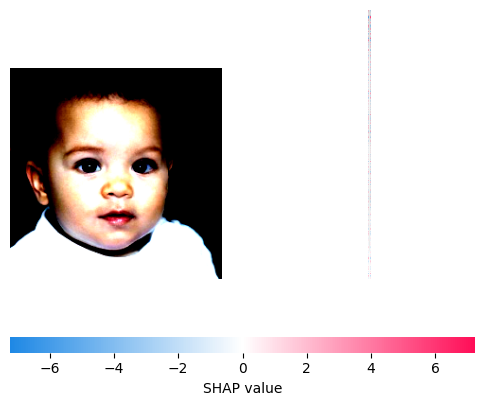

In [12]:
# Create a small subset of images as background for SHAP
background_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
background_images, _ = next(iter(background_loader))
background_images = background_images.to(DEVICE)

# Initialize the SHAP explainer
explainer = shap.GradientExplainer(model, background_images)

# Pick one image from the validation set
val_sample, val_label = val_dataset[0]
shap_input = val_sample.unsqueeze(0).to(DEVICE)

# Compute SHAP values (one array per class)
shap_values = explainer.shap_values(shap_input)

# (Optional) Transpose SHAP arrays from (1, channels, H, W) to (1, H, W, channels)
shap_values = [s.transpose(0, 2, 3, 1) for s in shap_values]

# Get prediction for selecting the corresponding SHAP values
pred = model(shap_input).argmax(dim=1).item()

# Prepare the pixel values as a NumPy array with shape (1, H, W, C)
pixel_values = np.array([np.array(val_sample.permute(1, 2, 0))])

# Visualize SHAP for the predicted class
shap.image_plot([shap_values[pred]], pixel_values)

## LIME Implementation

  0%|          | 0/1000 [00:00<?, ?it/s]

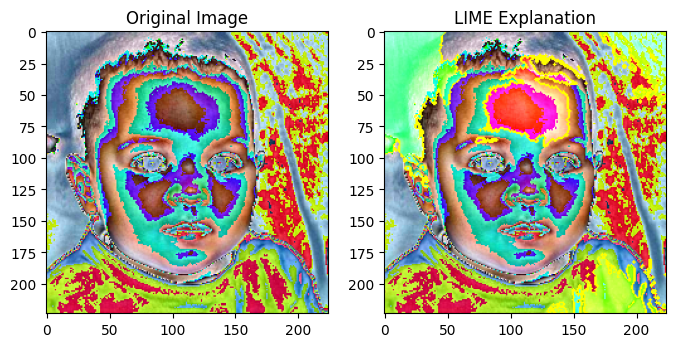

In [13]:
lime_explainer = lime_image.LimeImageExplainer()

def lime_predict(images):
    """
    images: list of images in RGB [0..255]
    We need to transform them to match the model’s input pipeline.
    Return Nx2 array of probabilities for (real, fake).
    """
    model.eval()
    batch = []
    for img in images:
        # Convert from numpy [H, W, C], 0..255 -> PIL -> transform -> tensor
        pil_img = Image.fromarray(np.uint8(img))
        t = val_transforms(pil_img)
        batch.append(t)
    batch = torch.stack(batch).to(DEVICE)
    with torch.no_grad():
        outputs = model(batch)
        probs = F.softmax(outputs, dim=1).cpu().numpy()
    return probs

# Example usage on the same val image
val_img_arr = np.array(val_sample.permute(1,2,0).cpu() * 255, dtype=np.uint8)

explanation = lime_explainer.explain_instance(
    val_img_arr,
    lime_predict,
    top_labels=2,
    hide_color=0,
    num_samples=1000  # number of perturbations
)

# Choose the label we want (predicted label, for instance)
lime_pred_label = model(val_sample.unsqueeze(0).to(DEVICE)).argmax(dim=1).item()

lime_temp, lime_mask = explanation.get_image_and_mask(
    label=lime_pred_label,
    positive_only=False,
    hide_rest=False,
    num_features=5,
    min_weight=0.0
)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title("Original Image")
plt.imshow(val_img_arr)

plt.subplot(1,2,2)
plt.title("LIME Explanation")
plt.imshow(mark_boundaries(lime_temp, lime_mask))
plt.show()


## Output Generation

In [ ]:
import os
from pathlib import Path

# Directories to save outputs
output_dir = Path("explanations")
gradcam_dir = output_dir / "gradcam"
lime_dir = output_dir / "lime"
(gradcam_dir / "real").mkdir(parents=True, exist_ok=True)
(gradcam_dir / "fake").mkdir(parents=True, exist_ok=True)
(lime_dir / "real").mkdir(parents=True, exist_ok=True)
(lime_dir / "fake").mkdir(parents=True, exist_ok=True)

# Collect 5 real and 5 fake images from test dataset
real_images = []
fake_images = []

for path, label in test_dataset.samples:
    if label == 0 and len(real_images) < 5:
        real_images.append((path, label))
    elif label == 1 and len(fake_images) < 5:
        fake_images.append((path, label))
    if len(real_images) == 5 and len(fake_images) == 5:
        break

selected_images = real_images + fake_images

# Process each image
for idx, (img_path, label) in enumerate(selected_images):
    label_name = "real" if label == 0 else "fake"
    pil_img = Image.open(img_path).convert("RGB")
    img_tensor = val_transforms(pil_img).unsqueeze(0).to(DEVICE)

    ### GRAD-CAM
    cam, pred_class = grad_cam(model, img_tensor)
    cam_overlay = show_grad_cam_on_image(pil_img, cam)
    cam_output_path = gradcam_dir / label_name / f"img_{idx}_{label_name}_gradcam.jpg"
    Image.fromarray(cam_overlay).save(cam_output_path)

    ### LIME
    img_arr = np.array(pil_img)
    explanation = lime_explainer.explain_instance(
        img_arr,
        lime_predict,
        top_labels=2,
        hide_color=0,
        num_samples=1000
    )
    lime_pred = model(img_tensor).argmax(dim=1).item()
    lime_img, lime_mask = explanation.get_image_and_mask(
        label=lime_pred,
        positive_only=False,
        hide_rest=False,
        num_features=5,
        min_weight=0.0
    )
    lime_output = mark_boundaries(lime_img, lime_mask)
    lime_output_path = lime_dir / label_name / f"img_{idx}_{label_name}_lime.jpg"
    plt.imsave(lime_output_path, lime_output)

print("Saved Grad-CAM and LIME outputs for 10 images.")
